In [358]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib as mpl
import matplotlib.animation as ani
from matplotlib.colors import Normalize
from IPython.display import HTML
import copy

In [359]:
# FUNCTIONS

def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

def divide(M1,M2):
    """To divide two numpy arrays M1/M2 element-wise and avoide division by zero"""
    f = np.divide(M1, M2, out=np.zeros_like(M1), where=M2!=0)
    return f

def density_func(M1,M2):
    '''Density dependent diffusion function'''
    f = divide(M1,1-M1-M2)
    return f

def den_dep_crossdiffusion(M1, M2):
    '''finite difference approximation of the diffusion term for M1'''
    
    M1_r = np.roll(M1, (0,-1), (0,1)) # right neighbor
    M1_l = np.roll(M1, (0,+1), (0,1)) # left neighbor
    M1_t = np.roll(M1, (-1,0), (0,1)) # top neighbor
    M1_b = np.roll(M1, (+1,0), (0,1)) # bottom neighbor
    
    M2_r = np.roll(M2, (0,-1), (0,1)) # right neighbor
    M2_l = np.roll(M2, (0,+1), (0,1)) # left neighbor
    M2_t = np.roll(M2, (-1,0), (0,1)) # top neighbor
    M2_b = np.roll(M2, (+1,0), (0,1)) # bottom neighbor
    
    D = (density_func(M1_r,M2_r)-density_func(M1_l,M2_l))*(M1_r+M2_r-M1_l-M2_l)/4 \
      + (density_func(M1_t,M2_t)-density_func(M1_b,M2_b))*(M1_t+M2_t-M1_b-M2_b)/4 \
      + density_func(M1,M2)*discrete_laplacian(M1+M2)
    
    return D

In [360]:
## MODEL PARAMETERS

# Cell
mu1 = 1.21/3600        # max growth rate of strain 1 (in 1/sec)
mu2 = 1.21/3600       # max growth rate of strain 2 (in 1/sec)
Cmax = 0.05           # max cell density (in g/mL dcw)
Y = 0.5               # biomass yield (in g biomass/g glucose)

# Glucose
Ks = 4*10**-6         # rate of nutrient consumption by Monod kinetics (in g/mL)

# Antibiotics
Km1 = 3.55*10**-6       # Michaelis-Menton rate constant for antibiotic 1 inactivation by C1 (in g/mL)
Vmax1 = 8*10**3/3600  # Maximum antibiotic 1 inactivation (by C1) rate (in mL/(g.sec))
IC1 = 0.65*10**-6          # antibiotic 1 concentration at which C2 growth rate is halved (in g/mL)
Km2 = 3.55*10**-6       # Michaelis-Menton rate constant for antibiotic 2 inactivation by C2 (in g/mL)
Vmax2 = 8*10**3/3600  # Maximum antibiotic 2 inactivation (by C2) rate (in mL/(g.sec))
IC2 = 0.65*10**-6          # antibiotic 2 concentration at which C1 growth rate is halved (in g/mL)

# Diffusion
DC = 50              # diffusion coefficient of biomass (in um^2/sec)
DS = 600              # diffusion coefficient of glucose (in um^2/sec)
DA1 = 400             # diffusion coefficient of antibiotic 1 (in um^2/sec)
DA2 = 400             # diffusion coefficient of antibiotic 2 (in um^2/sec)

# Initial condition
S0 = 0.004            # glucose concentration in feed medium (in g/mL)
A10 = 0.0001           # antiobiotic 1 concentration in feed medium (in g/mL)
A20 = 0.0001           # antiobiotic 2 concentration in feed medium (in g/mL)
f1 = 0.01              # initial density of loading sites for C1 (fraction of mesh points)
f2 = 0.01             # initial density of loading sites for C2 (fraction of mesh points)
C0 = 0.1             # inital biomass density at loading sites (dimensionless)

In [361]:
# Frame width (x and y axis - assuming square frame) in um
Len = 10000
# Space desolution in um
dx = 100 
dx0 = dx/Len
# Time Resolution in sec
dt = 1
dtau = dt*mu1
# Time steps
T = 100000
# Number of divisions in space
Lx = int(Len/dx)

res = dtau/dx0**2 

print("Frame dimensions are", Len, "X", Len, "micrometer sq. \n dx = ", dx, "micrometers")
print("Simulation time is", dt*T, "seconds \n dt =", dt, "seconds")
print("dtau / dx0^2 = ", res)

Frame dimensions are 10000 X 10000 micrometer sq. 
 dx =  100 micrometers
Simulation time is 100000 seconds 
 dt = 1 seconds
dtau / dx0^2 =  3.3611111111111107


In [362]:
# DIMENSIONLESS PARAMETERS

dC = DC/(mu1*Len**2)            # diffusion constant of biomass
dS = DS/(mu1*Len**2)            # diffusion constant of glucose
dA1 = DA1/(mu1*Len**2)          # diffusion constant of antibiotic 1
dA2 = DA2/(mu1*Len**2)          # diffusion constant of antibiotic 2

mu_r = mu2/mu1                 # relative instrinsic growth rate (of C2 wrt C1)

beta = (10**-2)*Cmax/(Y*Ks)             # Glucose utilization

alpha1 = Km1/IC1               # Antibiotic 1 strength
alpha2 = Km2/IC2               # Antibiotic 2 strength

gamma1 = (10**-4)*Vmax1*Cmax/(mu1*IC1)  # Benefit from C1 to C2 by antibiotic 1 inactivation 
gamma2 = Vmax2*Cmax/(mu1*IC2)  # Benefit from C2 to C1 by antibiotic 2 inactivation

Partial differential equations:

$\frac{\partial c_{1}}{\partial \tau} = \delta_{C}\nabla \cdot \Big( \frac{c_{1}}{1-c_{1}-c_{2}}\nabla (c_{1}+c_{2}) \Big) + \Big( \frac{s}{1+s}\Big) \Big( \frac{1}{1+a_{2}}\Big)c_{1}$

$\frac{\partial c_{2}}{\partial \tau} = \delta_{C}\nabla \cdot \Big( \frac{c_{2}}{1-c_{1}-c_{2}}\nabla (c_{1}+c_{2}) \Big) + \Big( \frac{s}{1+s}\Big) \Big( \frac{1}{1+a_{1}}\Big)\mu_{r}c_{2}$

$\frac{\partial s}{\partial \tau} = \delta_{S} \nabla^{2}s - \beta(c_{1} + \mu_{r}c_{2})\frac{s}{1+s}$

$\frac{\partial a_{1}}{\partial \tau} = \delta_{A1}\nabla^{2}a_{1} - \gamma_{1}\frac{a_{1}c_{1}}{\alpha_{1}+a_{1}}$

$\frac{\partial a_{2}}{\partial \tau} = \delta_{A2}\nabla^{2}a_{2} - \gamma_{2}\frac{a_{2}c_{2}}{\alpha_{2}+a_{2}}$

In [341]:
def update_2d(C1, C2, S, A1, A2):
    
    C1diff = res*dC*den_dep_crossdiffusion(C1, C2) + dtau*C1*S/((1+S)*(1+A2))
    C2diff = res*dC*den_dep_crossdiffusion(C2, C1) + dtau*mu_r*C2*S/((1+S)*(1+A1))
    Sdiff = res*dS*discrete_laplacian(S) - dtau*beta*(C1+mu_r*C2)*S/(1+S)
    A1diff = res*dA1*discrete_laplacian(A1) - dtau*gamma1*A1*C1/(alpha1+A1)
    A2diff = res*dA2*discrete_laplacian(A2) - dtau*gamma2*A2*C2/(alpha2+A2)
    
    C1 += C1diff
    C2 += C2diff
    S += Sdiff
    A1 += A1diff
    A2 += A2diff
    
    C1[C1 < 0] = 0
    C2[C2 < 0] = 0
    C1[C1 >= 1] = 0.9999999999
    C2[C2 >= 1] = 0.9999999999
    S[S < 0] = 0 
    A1[A1 < 0] = 0 
    A2[A2 < 0] = 0
    
    # Reflecting boundaries
    
    C1[0,:], C2[0,:], S[0,:], A1[0,:], A2[0,:] = C1[1,:], C2[1,:], S[1,:], A1[1,:], A2[1,:]            # top
    C1[-1,:], C2[-1,:], S[-1,:], A1[-1,:], A2[-1,:] = C1[-2,:], C2[-2,:], S[-2,:], A1[-2,:], A2[-2,:]  # bottom
    C1[:,0], C2[:,0], S[:,0], A1[:,0], A2[:,0] = C1[:,1], C2[:,1], S[:,1], A1[:,1], A2[:,1]            # left
    C1[:,-1], C2[:,-1], S[:,-1], A1[:,-1], A2[:,-1] = C1[:,-2], C2[:,-2], S[:,-2], A1[:,-2], A2[:,-2]  # right
    
    #C1[:,0], C2[:,0], S[:,0], A1[:,0], A2[:,0] = 0, 0, S0, A10, A20
    
    return C1, C2, S, A1, A2


def initialize_2d(C0, S0, A10, A20):
    
    '''Sampling a fraction of mesh points uniformly randomly and loading each with a fixed cell density'''
    
    C1 = np.zeros((Lx+1,Lx+1))
    C2 = np.zeros((Lx+1,Lx+1))
    S = np.ones((Lx+1,Lx+1))*S0/Ks
    A1 = np.ones((Lx+1,Lx+1))*A10/IC1
    A2 = np.ones((Lx+1,Lx+1))*A20/IC2
    
    # sample random points to load bacteria
    n1 = int(np.ceil(f1*(Lx-1)*(Lx-1)))
    n2 = int(np.ceil(f2*(Lx-1)*(Lx-1)))
    ind1 = np.random.randint(low=1, high=int((Lx-1)*(Lx-1)), size=n1)
    ind2 = np.random.randint(low=1, high=int((Lx-1)*(Lx-1)), size=n2)

    for i in ind1:
        x = int(np.ceil(i/(Lx-1)))
        y = i%(Lx-1)+1
        C1[x,y] = C0 
    
    for i in ind2:
        x = int(np.ceil(i/(Lx-1)))
        y = i%(Lx-1)+1
        C2[x,y] = C0 
        
    return(C1, C2, S, A1, A2)

def middle_initialize_2d():
    C1 = np.zeros((Lx+1,Lx+1))
    C2 = np.zeros((Lx+1,Lx+1))
    S = np.ones((Lx+1,Lx+1))*S0/Ks
    A1 = np.ones((Lx+1,Lx+1))*A10/IC1
    A2 = np.ones((Lx+1,Lx+1))*A20/IC2
    
    for i in range(48, 53): 
        for j in range(45, 50):
            C1[j,i] = 0.2
        for j in range(50,55):
            C2[j,i] = 0.2
    
    return(C1, C2, S, A1, A2)

In [318]:
# 2D simulation

update_every = 500 # number of time steps after which data is stored
C1_time = []
C2_time = []
S_time = []
A1_time = []
A2_time = []
C1, C2, S, A1, A2 = initialize_2d()

for tt in range(T):
    if tt%update_every == 0:
        C1_time.append(C1.copy())
        C2_time.append(C2.copy())
        S_time.append(S.copy())
        A1_time.append(A1.copy())
        A2_time.append(A2.copy())
    C1, C2, S, A1, A2 = update_2d(C1, C2, S, A1, A2)

print("end of simultaion")

end of simultaion


In [325]:
# Create image of final density distribution for C1 (Red) and C2 (Green)

brightness = 1 # factor to multiply brightness

rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
C1[C1<0] = 0
C2[C2<0] = 0
rgb[..., 0] = C1*256*brightness
rgb[..., 1] = C2*256*brightness
rgb[..., 0][rgb[..., 0]>255] = 255
rgb[..., 1][rgb[..., 1]>255] = 255
img = Image.fromarray(rgb)
img.resize((500,500), Image.ANTIALIAS)

img.save('figs/b_-2_g1_-4.gif')

In [320]:
# Total fractional abundance of C1
print(np.sum(C1)/np.sum(C1+C2))

0.9025868541229716


In [315]:
# Create GIF of evolution of the community

images=[]
for i in range(len(C1_time)):
    rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
    C1_time[i][C1_time[i]<0] = 0
    C2_time[i][C2_time[i]<0] = 0
    rgb[..., 0] = (C1_time[i])*256
    rgb[..., 1] = (C2_time[i])*256
    rgb[..., 0][rgb[..., 0]>255] = 255
    rgb[..., 1][rgb[..., 1]>255] = 255
    img = Image.fromarray(rgb)
    images.append(img.resize((500,500), Image.ANTIALIAS))

images[0].save('b_-2_g1_-2.gif', format='GIF', append_images=images[1:], save_all=True, duration=1, loop=0)

In [ ]:
### PARAMETER STUDY

b = [-2,2]
a1 = [-4, -2, 0 ,2, 4]
g1 = [-4, -2, 0, 2, 4]

for bi in b:
    for a1i in a1:
        for g1i in g1:
            
            dC = DC/(mu1*Len**2)            # diffusion constant of biomass
            dS = DS/(mu1*Len**2)            # diffusion constant of glucose
            dA1 = DA1/(mu1*Len**2)          # diffusion constant of antibiotic 1
            dA2 = DA2/(mu1*Len**2)          # diffusion constant of antibiotic 2

            mu_r = mu2/mu1                 # relative instrinsic growth rate (of C2 wrt C1)

            beta = Cmax/(Y*Ks)             # Glucose utilization

            alpha1 = (10**a1i)*Km1/IC1               # Antibiotic 1 strength
            alpha2 = Km2/IC2               # Antibiotic 2 strength

            gamma1 = (10**g1i)*Vmax1*Cmax/(mu1*IC1)  # Benefit from C1 to C2 by antibiotic 1 inactivation 
            gamma2 = Vmax2*Cmax/(mu1*IC2)  # Benefit from C2 to C1 by antibiotic 2 inactivation
            
            # 2D simulation

            update_every = 500 # number of time steps after which data is stored
            C1_time = []
            C2_time = []
            S_time = []
            A1_time = []
            A2_time = []
            C1, C2, S, A1, A2 = initialize_2d(C0, S0, A10, (10**bi)*A20)
            
            for tt in range(T):
                if tt%update_every == 0:
                    C1_time.append(C1.copy())
                    C2_time.append(C2.copy())
                    S_time.append(S.copy())
                    A1_time.append(A1.copy())
                    A2_time.append(A2.copy())
                C1, C2, S, A1, A2 = update_2d(C1, C2, S, A1, A2)

            print("end of simultaion for b2_{}_a1_{}_g1_{}".format(bi,a1i,g1i))
            
            rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
            C1[C1<0] = 0
            C2[C2<0] = 0
            rgb[..., 0] = C1*256*5
            rgb[..., 1] = C2*256*5
            rgb[..., 0][rgb[..., 0]>256] = 256
            rgb[..., 1][rgb[..., 1]>256] = 256
            img = Image.fromarray(rgb)
            img.resize((500,500), Image.ANTIALIAS)
            
            img.save('figs/b2_{}_a1_{}_g1_{}.png'.format(bi,a1i,g1i))
            
            images=[]
            for i in range(len(C1_time)):
                rgb = np.zeros((Lx+1,Lx+1,3), 'uint8')
                C1_time[i][C1_time[i]<0] = 0
                C2_time[i][C2_time[i]<0] = 0
                rgb[..., 0] = (C1_time[i])*256*5
                rgb[..., 1] = (C2_time[i])*256*5
                rgb[..., 0][rgb[..., 0]>256] = 255
                rgb[..., 1][rgb[..., 1]>256] = 255
                img = Image.fromarray(rgb)
                images.append(img.resize((500,500), Image.ANTIALIAS))

            images[0].save('gifs/b2_{}_a1_{}_g1_{}.gif'.format(bi,a1i,g1i), format='GIF', append_images=images[1:], save_all=True, duration=1, loop=0)
            

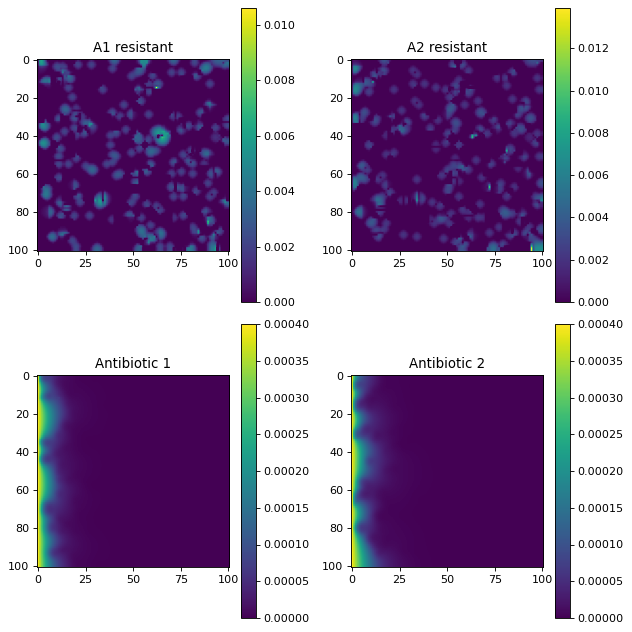

In [129]:
def buildmeplot_2d(i=int):
    iv = min(i, len(C1_time) - 1)
    plt.clf()
    
    plt.subplot(221)
    plt.imshow(C1_time[iv], vmin=0)
    plt.title('A1 resistant')
    plt.colorbar()
    
    plt.subplot(222)
    plt.imshow(C2_time[iv], vmin=0)
    plt.title('A2 resistant')
    plt.colorbar()
    
    plt.subplot(223)
    plt.imshow(A1_time[iv], vmin=0)
    plt.title('Antibiotic 1')
    plt.colorbar()
    
    plt.subplot(224)
    plt.imshow(A2_time[iv], vmin=0)
    plt.title('Antibiotic 2')
    plt.colorbar()
    
    plt.tight_layout()
    
fig = plt.figure(figsize=(8, 8), dpi=80)
animator = ani.FuncAnimation(fig, buildmeplot_2d, interval=100, frames=int(np.floor(T/update_every)))
HTML(animator.to_html5_video())

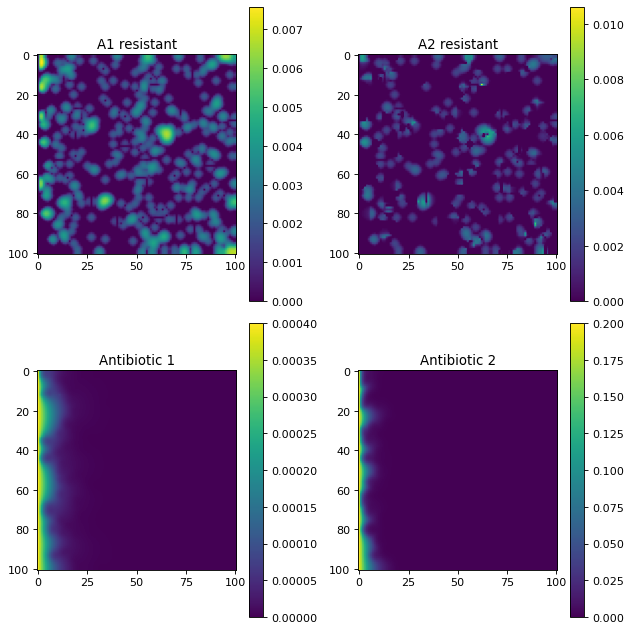

In [142]:
fig = plt.figure(figsize=(8, 8), dpi=80)

plt.subplot(221)
plt.imshow(C1+C2, vmin=0)
plt.title('A1 resistant')
plt.colorbar()
    
plt.subplot(222)
plt.imshow(C1, vmin=0)
plt.title('A2 resistant')
plt.colorbar()
    
plt.subplot(223)
plt.imshow(A1, vmin=0)
plt.title('Antibiotic 1')
plt.colorbar()
    
plt.subplot(224)
plt.imshow(S, vmin=0)
plt.title('Antibiotic 2')
plt.colorbar()
    
plt.tight_layout()